GAN and DCGAN


In [87]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch 
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
 
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # This will generate a random seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
 
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)
print("1.mnist digit\n2.mnist fashion\n3.anime faces\n4.celbrity face\n")
n=int(input("enter your choice:"))
while(n>4 or n<1):
    print("enter a valid choice:")
    n=int(input())

Random Seed:  999
cuda:0
1.mnist digit
2.mnist fashion
3.anime faces
4.celbrity face



In [88]:
if(n==1):
    batch_size = 500
    epochs = 50000
    noise_dim = 100
    (train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
    #(train_images, train_labels), (_, _) = keras.datasets.cifar10.load_data()
    #(train_images, train_labels), (_, _) = keras.datasets.fashion_mnist.load_data()


    train_images = train_images[:batch_size].reshape(batch_size, 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5
elif(n==2):
    batch_size = 500
    epochs = 50000
    noise_dim = 100
    #(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
    #(train_images, train_labels), (_, _) = keras.datasets.cifar10.load_data()
    (train_images, train_labels), (_, _) = keras.datasets.fashion_mnist.load_data()


    train_images = train_images[:batch_size].reshape(batch_size, 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5
elif(n==3):
    transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # We can use an image folder dataset the way we have it setup.
    # Create the dataset
    dataset = datasets.ImageFolder(root="animages1",
                                transform=transform)
    # Create the dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                            shuffle=True, num_workers=2)
else:
    transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # We can use an image folder dataset the way we have it setup.
    # Create the dataset
    dataset = datasets.ImageFolder(root="exp",
                                transform=transform)
    # Create the dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                            shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


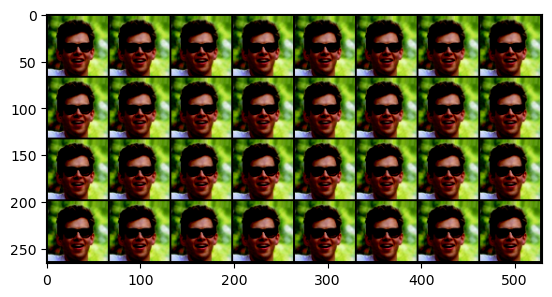

In [89]:
#displaying the dataset images
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
 
# We will take one batch of data and show the distribution of pixels in one sample image
if(n<3):
  fig, axs = plt.subplots(3, 3, figsize=(5, 5))
  axs = axs.flatten()
  for i in range(9):  
    
    axs[i].imshow(train_images[i], cmap='gray')
    axs[i].axis('off')
  plt.show()
     

else:
  data_iter = iter(data_loader)
  images, labels = next(data_iter)
 
  imshow(torchvision.utils.make_grid(images))

In [91]:
#creating generator model
if(n<3):
    def make_generator_model():
        model = keras.Sequential()
        model.add(layers.Dense(256, input_shape=(100,), use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(512, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(784, activation='tanh'))
        model.add(layers.Reshape((28, 28, 1)))

        return model
else:
    # Creating a function that will create a normal distribution of weights to the Convolutional layers
    def init_normal(m):
        classname = m.__class__.__name__
    
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    feature_map       = 64
    latent_space_size = 100
    class Generator(nn.Module):
        
        def __init__(self):
            
            super(Generator, self).__init__()
            
            self.convTranspose1 = nn.ConvTranspose2d( latent_space_size, feature_map * 8, 4, 1, 0, bias=False)
            self.convTranspose2 = nn.ConvTranspose2d( feature_map * 8  , feature_map * 4, 4, 2, 1, bias=False)
            self.convTranspose3 = nn.ConvTranspose2d( feature_map * 4  , feature_map * 2, 4, 2, 1, bias=False)
            self.convTranspose4 = nn.ConvTranspose2d( feature_map * 2  , feature_map * 1, 4, 2, 1, bias=False)
            self.convTranspose5 = nn.ConvTranspose2d( feature_map * 1  , 3              , 4, 2, 1, bias=False)
    
            self.bnorm1 = nn.BatchNorm2d(feature_map * 8)
            self.bnorm2 = nn.BatchNorm2d(feature_map * 4)
            self.bnorm3 = nn.BatchNorm2d(feature_map * 2)
            self.bnorm4 = nn.BatchNorm2d(feature_map * 1)
    
        def forward(self, x):
            x = self.convTranspose1(x)
            x = F.relu(self.bnorm1(x))
    
            x = self.convTranspose2(x)
            x = F.relu(self.bnorm2(x))
    
            x = self.convTranspose3(x)
            x = F.relu(self.bnorm3(x))
    
            x = self.convTranspose4(x)
            x = F.relu(self.bnorm4(x))
    
            x = self.convTranspose5(x)
            x = torch.tanh(x)
            return x
    
    # Create the generator
    generator = Generator().to(device)



    # Helper function for creating a random latent vector
    def generate_latent_vectors_z(N):
        z = torch.randn(N, 100, 1, 1, device=device)
        return z  

In [92]:
# Helper function for creating a random latent vector
def generate_latent_vectors_z(N):
    z = torch.randn(N, 100, 1, 1, device=device)
    return z  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


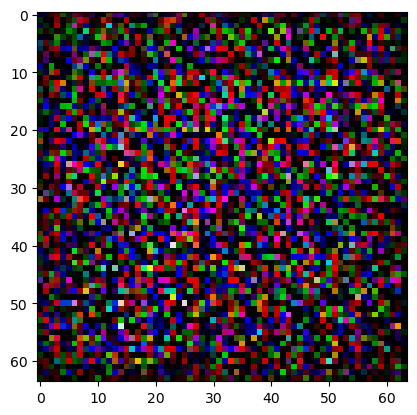

In [93]:
# Generate a random latent space of 100 elements which we will use to transform to an image
z = generate_latent_vectors_z(1).to(device)
random_noise = generator(z)
 
plt.imshow(random_noise[0].cpu().permute(1, 2, 0).detach().numpy())

In [94]:
#creating discriminator model
if(n<3):
    print("HI")
    def make_discriminator_model():
        model = keras.Sequential()
        model.add(layers.Flatten())
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(1))

        return model
else:
    print("Hello")
    class Discriminator(nn.Module):
        
        def __init__(self):
            
            super(Discriminator, self).__init__()
            
            self.conv1 = nn.Conv2d(3              , feature_map    , 4, 2, 1, bias=False)
            self.conv2 = nn.Conv2d(feature_map    , feature_map * 2, 4, 2, 1, bias=False)
            self.conv3 = nn.Conv2d(feature_map * 2, feature_map * 4, 4, 2, 1, bias=False)
            self.conv4 = nn.Conv2d(feature_map * 4, feature_map * 8, 4, 2, 1, bias=False)
            self.conv5 = nn.Conv2d(feature_map * 8, 1              , 4, 1, 0, bias=False)
    
            self.bnorm1 = nn.BatchNorm2d(feature_map*2)
            self.bnorm2 = nn.BatchNorm2d(feature_map*4)
            self.bnorm3 = nn.BatchNorm2d(feature_map*8)
    
            self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            x = F.leaky_relu(self.conv1(x))
    
            x = self.conv2(x)
            x = F.leaky_relu(self.bnorm1(x))
    
            x = self.conv3(x)
            x = F.leaky_relu(self.bnorm2(x))
            
            x = self.conv4(x)
            x = F.leaky_relu(self.bnorm3(x))
    
            x = self.conv5(x)
            x = self.sigmoid(x)
            return x

Hello


In [95]:
if(n<3):
    
    # Define the loss functions
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # Define the optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    # Create the GAN model
    def make_gan_model(generator, discriminator):
        model = keras.Sequential()
        1


        model.add(generator)
        model.add(discriminator)
        
        return model
    # Instantiate the models and the GAN model
    generator = make_generator_model()
    discriminator = make_discriminator_model()
    gan_model = make_gan_model(generator, discriminator)
    

else:
    # Initialize BCELoss function
    criterion = nn.BCELoss()
    
    # Models
    generator =     Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Use the modules apply function to recursively apply the initialization
    generator.apply(init_normal)
    discriminator.apply(init_normal)
    
    # Optimizers
    generator_optimizer     = torch.optim.Adam(generator.parameters(),     lr=0.0002)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

In [96]:
#loading the model
if(n==1):
    generator = tf.keras.models.load_model("my_generatormnist.h5")
    discriminator = tf.keras.models.load_model("my_discriminatormnist.h5")
    gan_model = tf.keras.models.load_model("my_ganmodelmnist.h5")
elif(n==2):
    generator = tf.keras.models.load_model("my_generatorfashion.h5")
    discriminator = tf.keras.models.load_model("my_discriminatorfashion.h5")
    gan_model = tf.keras.models.load_model("my_ganmodelfashion.h5")
elif(n==3):
    generator = Generator()
    generator.load_state_dict(torch.load("DCGAN_anime_generator.pth"))
    generator.eval()
    if torch.cuda.is_available():
        generator.cuda()
    discriminator = Discriminator()
    discriminator.load_state_dict(torch.load("DCGAN_anime_discriminator.pth"))
    discriminator.eval()
    if torch.cuda.is_available():
        discriminator.cuda()
        
else:
    generator = Generator()
    generator.load_state_dict(torch.load("DCGAN_celeba2_generator.pth"))
    generator.eval()
    if torch.cuda.is_available():
        generator.cuda()
    discriminator = Discriminator()
    discriminator.load_state_dict(torch.load("DCGAN_celeba2_discriminator.pth"))
    discriminator.eval()
    if torch.cuda.is_available():
        discriminator.cuda()

In [97]:
# Training Loop
# Define the training loop
if(n<3):
    @tf.function
    def train_step(images):
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Train the model
    batch_size = 500
    epochs = 10
    noise_dim = 100

    #(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
    #(train_images, train_labels), (_, _) = keras.datasets.cifar10.load_data()
    (train_images, train_labels), (_, _) = keras.datasets.fashion_mnist.load_data()


    train_images = train_images[:batch_size].reshape(batch_size, 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5

    for epoch in range(epochs):
        for i in range(train_images.shape[0] // batch_size):
            batch_images = train_images[i * batch_size : (i+1) * batch_size]
            train_step(batch_images)

        if epoch % 1000 == 0:
            print(f'Epoch {epoch+1}/{epochs}')
            noise = tf.random.normal([1, noise_dim])
            generated_image = generator(noise, training=False)
            generated_image = generated_image.numpy().reshape
            
    #model.save("my_model.h")

else:
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=500,
                                            shuffle=True, num_workers=2)
    print("Starting Training Loop...")
    epochs =1
    N_samples = 128
        
    # For each epoch
    for epoch in range(epochs):
    # For each batch in the dataloader
        for idx, images in enumerate(data_loader):
            discriminator.zero_grad()
        
            if (idx%100 ==0):
                print(f"{epoch}/{epochs} epoch | {idx}/{len(data_loader)} batch \n")
        
            # Generate examples of real data
            real_data = images[0].to(device)
            real_data_label = torch.ones(real_data.shape[0]).to(device)
        
            # Training of Discriminator
            # Forward pass real batch through discriminator
            output = discriminator(real_data).view(-1)
            errD_real = criterion(output, real_data_label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
        
            # Create fake data with a generator
            z = generate_latent_vectors_z(len(real_data)).to(device)
            fake_data = generator(z)
            fake_data_label = torch.zeros(fake_data.shape[0]).to(device)
        
            # Forward pass fake data through discriminator
            output = discriminator(fake_data.detach()).view(-1)
            errD_fake = criterion(output, fake_data_label)
            errD_fake.backward()
        
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update discriminator
            discriminator_optimizer.step()
        
            # Training of Generator
            generator.zero_grad()
            real_data_label = torch.ones(fake_data.shape[0]).to(device) # fake labels are real for generator cost
            output = discriminator(fake_data).view(-1)
            errG = criterion(output, real_data_label)
            errG.backward()
        
            # Update Generator
            generator_optimizer.step()

Starting Training Loop...
0/1 epoch | 0/10 batch 



In [39]:
#generator.save("my_generatorfashion.h5")
#discriminator.save("my_discriminatorfashion.h5")
#gan_model.save("my_ganmodelfashion.h5")


In [ ]:
#saving the models

#torch.save(generator.state_dict(), 'DCGAN_celeba2_generator.pth')
#torch.save(discriminator.state_dict(), 'DCGAN_celeba2_discriminator.pth')    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


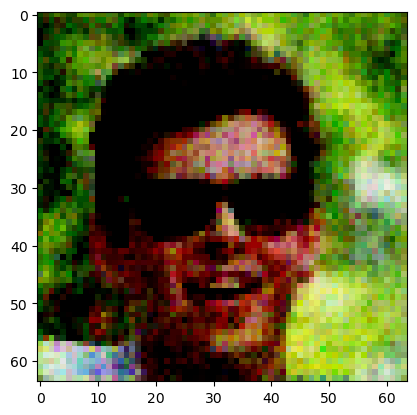

In [99]:
if(n<3):
    # Generate images using the trained generator
    num_images_to_generate = 32
    noise = tf.random.normal([num_images_to_generate, noise_dim])
    generated_images = generator(noise, training=False)

    # Plot the generated images
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(4, 8, figsize=(10, 10))
    axs = axs.flatten()
    for i in range(num_images_to_generate):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.show()
elif(n==3):
    # Assuming the generator generates len(real_data) fake images
    z = generate_latent_vectors_z(len(real_data)).to(device)

    # Generating fake data (images) using the generator
    fake_data = generator(z)

    # Determine the number of images generated
    num_images_generated = len(fake_data)

    # Creating a grid to display the images
    rows = 4
    cols = min(8, num_images_generated // rows)  # Calculate the number of columns based on the available images

    # Create a subplots grid
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Plotting each generated image in the grid
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_images_generated:  # Check if the index is within bounds
                img = fake_data[index].cpu().permute(1, 2, 0).detach().numpy()
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
            else:  # If there are no more images to display, break out of the loop
                break
    # Displaying the grid of images
    plt.tight_layout()
    plt.show()
else:
   z = generate_latent_vectors_z(1).to(device)
   random_noise = generator(z)
 
   plt.imshow(random_noise[0].cpu().permute(1, 2, 0).detach().numpy()) 
